## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, MultiLineString, Point, LineString

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [13]:
save = True

## Required data

### Required data - Area of Interest

<Axes: >

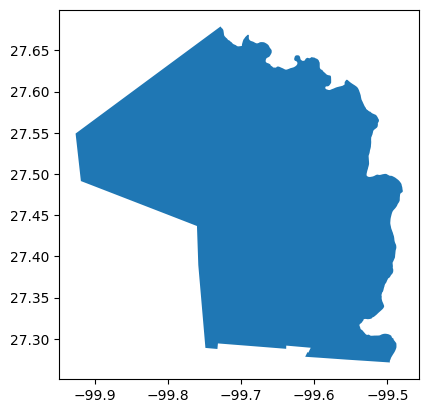

In [2]:
city = 'Nuevo Laredo'

# Source Data
schema = 'marco'
folder = 'mpos_2020'

# Downloads hexagons within 'city'
query = f"SELECT * FROM {schema}.{folder} WHERE \"NOMGEO\" LIKE \'{city}\'"
mpo = aup.gdf_from_query(query, geometry_col='geometry')

mpo.plot()

In [3]:
aoi = mpo.copy()

### Required data - nodes and edges from notebook prox_loading_osmnx 1 [Script 07-download_osmnx]

In [4]:
nodes = gpd.read_file("../../data/external/temporal_fromjupyter/nodes.gpkg")

#Show
print(nodes.shape)
nodes.head(2)

(25712, 5)


,osmid,x,y,street_count,geometry
0,229142483,-99.535591,27.629201,3,POINT (-99.53559 27.62920)
1,229142517,-99.495918,27.512994,4,POINT (-99.49592 27.51299)


In [6]:
#poly_wkt = aoi.dissolve().geometry.to_wkt()[0]
# Creates query to download nodes
#query = f"SELECT * FROM osmnx.nodes WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
#nodes = aup.gdf_from_query(query, geometry_col='geometry')

#Show
#print(nodes.shape)
#nodes.head(2)

In [5]:
edges = gpd.read_file("../../data/external/temporal_fromjupyter/edges.gpkg")

#Show
print(edges.shape)
edges.head(2)

(70645, 18)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,21332716,229416549,229142483,0,False,NaN,Trade Center Boulevard,unclassified,NaN,202.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-99.53559 27.62920, -99.53746 27.6..."
1,21302430,10798126756,229142483,0,False,NaN,Industry Avenue,unclassified,NaN,553.562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-99.53559 27.62920, -99.53348 27.6..."


In [7]:
#poly_wkt = aoi.dissolve().geometry.to_wkt()[0]
# Creates query to download edges
#query = f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
#edges = aup.gdf_from_query(query, geometry_col='geometry')

#Show
#print(edges.shape)
#edges.head(2)

### Required data - Points of interest

In [8]:
poly_wkt = aoi.dissolve().geometry.to_wkt()[0]
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.denue_2022 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
denue = aup.gdf_from_query(query, geometry_col='geometry')

pois = denue[['id', 'codigo_act', 'geometry']]

#Show
print(pois.shape)
pois.head(2)

(15105, 3)


,id,codigo_act,geometry
0,8292733,322299,POINT (-99.50178 27.48765)
1,9041161,326212,POINT (-99.51682 27.46476)


## Step 2: define graph_from_hippo without loading from a database

### Necessary definitions - graph_from_hippo

In [9]:
def graph_from_nodes_and_edges(gdf, nodes, edges):
    # ------------------------------------------------------ CODE CHANGE NEEDED: INSTEAD OF QUERRING FROM DB FROM A POLY_WKT, OVERLAY IS USED.
    # Query edges intersecting area of interest
    edges_gdf = gpd.overlay(gdf,edges,keep_geom_type=False)

    # Delete useless columns resulting from overlay
    edges_columns = [
        "osmid",
        "v",
        "u",
        "key",
        "oneway",
        "lanes",
        "name",
        "highway",
        "maxspeed",
        "length",
        "geometry",
        "bridge",
        "ref",
        "junction",
        "tunnel",
        "access",
        "width",
        "service",
    ]

    edges_gdf = edges_gdf[edges_columns]

    # Find nodes belonging to those querried edges
    nodes_id = list(edges_gdf.v.unique())
    u = list(edges_gdf.u.unique())
    nodes_id.extend(u)
    myset = set(nodes_id)
    nodes_id = list(myset)

    # ------------------------------------------------------ CODE CHANGE NEEDED: INSTEAD OF QUERRING FROM DB WHERE osmid IN {str(tuple(nodes_id))}, isin(nodes_id list) IS USED.
    # Query those nodes
    idx = nodes['osmid'].isin(nodes_id)
    nodes_gdf = nodes.loc[idx]

    # Drop duplicates
    #                                       ----------------------------------- ERROR, CONSULTAR CON EDGAR: ---------- Usando este method sale "TypeError: unhashable type: 'list'".
    edges_gdf.drop_duplicates(inplace=True) 
    #edges_gdf = edges_gdf.loc[edges_gdf.astype(str).drop_duplicates().index]
    nodes_gdf.drop_duplicates(inplace=True)

    # Format
    nodes_gdf = nodes_gdf.set_index('osmid')
    edges_gdf = edges_gdf.set_index(["u", "v", "key"])

    nodes_gdf = nodes_gdf.set_crs("EPSG:4326")
    edges_gdf = edges_gdf.set_crs("EPSG:4326")

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Querried and formated nodes and edges within area of interest.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    # Making sure all nodes belonging to edges_gdf are present in nodes_gdf
    nodes_tmp = nodes_gdf.reset_index().copy()
    edges_tmp = edges_gdf.reset_index().copy()

    # Current nodes in nodes_gdf
    nodes_dict = nodes_tmp.to_dict()

    # U nodes
    # U nodes that are in edges_tmp but not in nodes_tmp
    from_osmid = list(set(edges_tmp['u'].to_list()).difference(set(nodes_tmp.osmid.to_list())))

    # Iterating over each missing U node and adding its data to nodes_dict
    for i in from_osmid:
        row = edges_tmp.loc[(edges_tmp.u==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]

        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = first_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = first_coord[1]
        nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(first_coord)

    # V nodes
    # V nodes that are in edges_tmp but not in nodes_dict                                                      #Duda para Edgar: ¿Por qué en U nodes revisamos nodes_tmp pero en V nodes revisamos nodes_dict?
    to_osmid = list(set(edges_tmp['v'].to_list()).difference(set(list(nodes_dict['osmid'].values()))))

    # Iterating over each missing V node and adding its data to nodes_dict
    for i in to_osmid:
        row = edges_tmp.loc[(edges_tmp.v==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]

        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = last_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = last_coord[1]
        nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(last_coord)

    # Rewriting nodes_gdf from updated nodes_dict
    nodes_tmp = pd.DataFrame.from_dict(nodes_dict)
    nodes_tmp = gpd.GeoDataFrame(nodes_tmp, crs="EPSG:4326", geometry='geometry')
    nodes_gdf = nodes_tmp.copy()
    nodes_gdf.set_index('osmid',inplace=True)    

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Missing nodes from edges added to nodes gdf.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Created graph.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    return G, nodes_gdf, edges_gdf

In [10]:
def pois_nodes_distance(aoi, nodes, edges, pois):
    G, nodes_gdf, edges_gdf = graph_from_nodes_and_edges(aoi, nodes, edges)

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Created network.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    pois = pois.set_crs("EPSG:4326")
    nodes = nodes.set_crs("EPSG:4326")
    edges = edges.set_crs("EPSG:4326")

    nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Calculated distances from pois to nearest node.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    return nearest

In [11]:
nearest = pois_nodes_distance(aoi, nodes, edges, pois)

/tmp/ipykernel_25813/3734518090.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_gdf.drop_duplicates(inplace=True)


Querried and formated nodes and edges within area of interest.
Missing nodes from edges added to nodes gdf.
Created graph.
Created network.
Calculated distances from pois to nearest node.


In [12]:
#Show
print(nearest.shape)
nearest.head(2)

(15105, 5)


,id,codigo_act,geometry,osmid,distance_node
0,8292733,322299,POINT (-99.50178 27.48765),11319,11.389133
1,9041161,326212,POINT (-99.51682 27.46476),10124,71.458501


In [14]:
if save:
    nodes.to_file('../../data/external/temporal_fromjupyter/pois_distance_node.gpkg', driver='GPKG')